# Canadian Rental Prices Regression Model

We're going to work with the data preprocessed in [this notebook](DataPreprocessing.ipynb), which contains rental price data associated with multiple factors like the location, type of rental, number of rooms, etc. 

The price is our target variable. We're going to explore different regularized regression models before choosing a final regression model that we will use to predict new rental prices.

In [4]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.stats as stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [5]:
# Load data
with open('Data/preprocessed_data.pkl', 'rb') as handle:
    data = pickle.load(handle)

pc_frequency_map = data['pc_frequency_map']
df = data['df']

df.shape

(18832, 11)

### Create helper functions

In [7]:
def residual_analysis_plots(model):
    '''Plots the residuals and the Q-Q Plot in the same figure'''
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(15, 6))
    
    sns.scatterplot(x=model.predict(), y=model.resid, ax=ax1)
    ax1.set_title("Residual Plot")
    ax1.set_xlabel("Prediction")
    ax1.set_ylabel("Residuals")
    ax1.axhline(0, linestyle="--", color="orange")

    ax2.hist(model.resid, bins=30)
    ax2.set_title("Distribution of the residuals")
    
    stats.probplot(model.resid, dist="norm", plot=ax3)
    ax3.set_title("Normal Q-Q Plot")  

    plt.tight_layout()
    plt.show()

In [8]:
def eval_performance(test, predictions):
    MAE = mean_absolute_error(test, predictions)
    MSE = mean_squared_error(test, predictions)
    RMSE = np.sqrt(MSE)
    test_mean = test.mean()
    pred_mean = predictions.mean()
    ratio = RMSE / test_mean
    
    metrics = {
        'MAE': MAE,
        'MSE': MSE,
        'RMSE': RMSE,
        'Test Mean': test_mean,
        'Predictions Mean': pred_mean,
        'RMSE to mean ratio': ratio
    }

    df = pd.DataFrame(metrics.items(), columns=['Metric', 'Value'])
    df['Value'] = df['Value'].apply(lambda x: '%.4f' % x)
    
    return df

In [9]:
def compare_performances(initial_perf, current_perf):
    df = pd.merge(initial_perf, current_perf, on='Metric', suffixes=['_initial', '_current'])
    df['Difference'] = df['Value_current'].astype('float') - df['Value_initial'].astype('float')
    return df

In [ ]:
def find_optimal_degree:
    train_rmse_errors = []
    test_rmse_errors = []
    degrees = []
    
    for d in range(1, 11):
        polynomial_converter = PolynomialFeatures(degree=d, include_bias=False)
        poly_features = polynomial_converter.fit_transform(X)
        
        X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.15, random_state=42)
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        model = LinearRegression()
        model.fit(X_train_scaled, y_train)
        
        train_pred = model.predict(X_train_scaled)
        test_pred = model.predict(X_test_scaled)
        
        train_RMSE = np.sqrt(mean_squared_error(y_train, train_pred))
        test_RMSE = np.sqrt(mean_squared_error(y_test, test_pred))
        
        train_rmse_errors.append(train_RMSE)
        test_rmse_errors.append(test_RMSE)
        degrees.append(d)

    results_df = pd.DataFrame({
        'Degree': degrees,
        'Train RMSE': train_rmse_errors.apply(lambda x: '%.4f' % x),
        'Test RMSE': test_rmse_errors.apply(lambda x: '%.4f' % x),
    })

    return results_df.sort_values(by=['Test RMSE', 'Train RMSE']).head(1)

---

## 1. Initial regression model (linear regression)

### 1.1 Without scaling

In [13]:
# Separate features and target variable
X = df.drop('price', axis=1)
y = df['price']

In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [15]:
# Fit model
X_constant = sm.add_constant(X_train)
model = sm.OLS(y_train, X_constant).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     858.9
Date:                Sat, 01 Feb 2025   Prob (F-statistic):               0.00
Time:                        11:11:16   Log-Likelihood:            -1.2882e+05
No. Observations:               16007   AIC:                         2.577e+05
Df Residuals:                   15996   BIC:                         2.577e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    986.0061     34.815     28.321      0.000     917.764    1054.248
beds                     188.8547      8.814     21.428      0.000     171.579     206.130
baths                    460.8042     13.579     33.934      0.000     434.187     487.421
sq_feet                    0.3159      0.016     19.867      0.000       0.285       0.347
cats                     -70.4508     24.253     -2.905      0.004    -117.989     -22.913
dogs                     203.0738     23.390      8.682      0.000     157.228     248.920
postal_code                0.4020      0.069      5.840      0.000       0.267       0.537
type_Apartment           411.7612     17.685     23.283      0.000     377.097     446.425
type_Basement           -198.7112     30.267     -6.565      0.000    -258.038    -139.385
type_Room For Rent     -1573.6896     45.881    -34.299      0.000   -1663.621   -1483.758
furnishing_Unfurnished  -493.3721     24.292    -20.310      0.000    -540.988    -445.757
==============================================================================
Omnibus:                    19340.912   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         13919615.752
Skew:                           5.827   Prob(JB):                         0.00
Kurtosis:                     146.995   Cond. No.                     9.18e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Observations**
The R-squared is 0.349, which indicates that 34.9% of the variance of the price is explained by the model, which suggests a poor fit.
Based on the p-values, all features seem to be statistically significant.
The Durbin-Watson score of 1.985 indicates that the errors are independent.

In [17]:
# Evaluate performance
X_test_constant = sm.add_constant(X_test)
y_pred = model.predict(X_test_constant)
initial_performance = eval_performance(y_test, y_pred)
initial_performance

,Metric,Value
0,MAE,483.7449
1,MSE,531141.3258
2,RMSE,728.7944
3,Test Mean,2168.4823
4,Predictions Mean,2158.9867
5,RMSE to mean ratio,0.3361


**Observations**

Compared to the mean values, the MAE and RMSE are pretty high, which indicates our model doesn't perform really well.

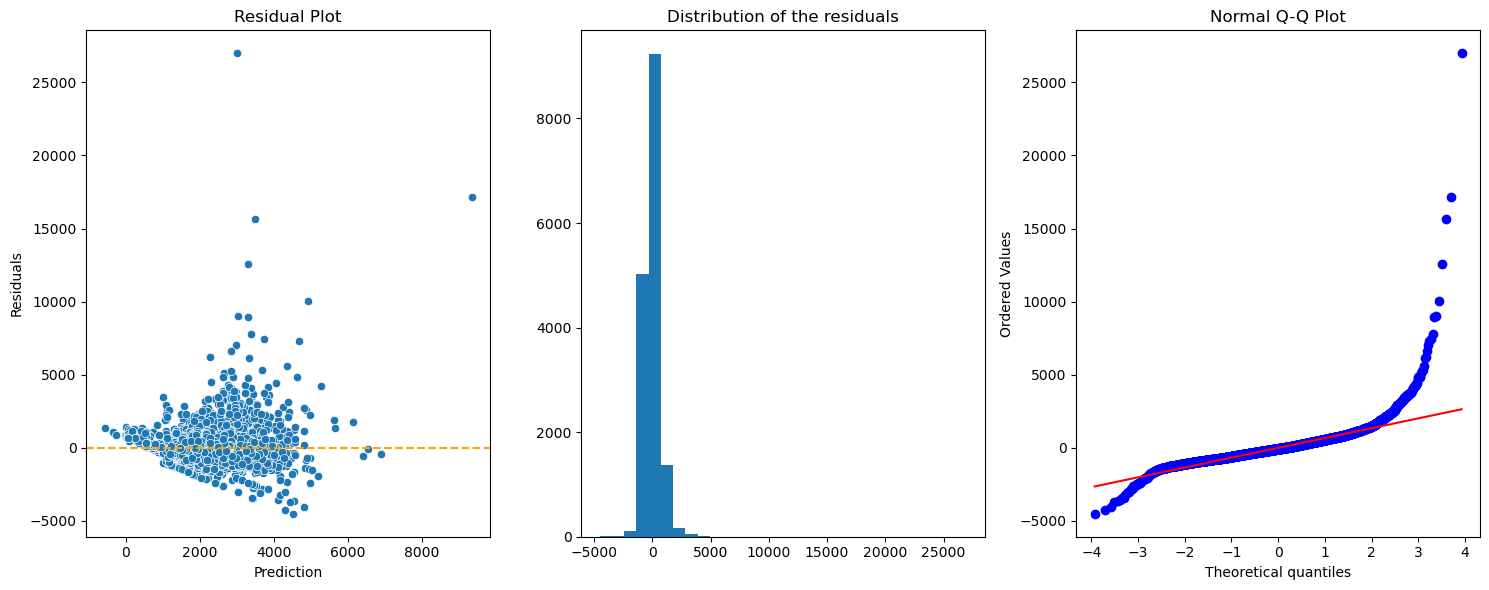

In [19]:
# Plot residuals
residual_analysis_plots(model)

**Observations**

The residuals do not seem to be independent and normally distributed. Looking at the Q-Q Plot, we can also see that there are a lot of outliers, especially for the higher prices.

### 1.2 With scaling

In [22]:
# Separate features and target variable
X = df.drop('price', axis=1)
y = df['price']

In [23]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [24]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#X_train_scaled = pd.DataFrame(X_train_scaled, columns=scaler.get_feature_names_out())
#X_test_scaled = pd.DataFrame(X_test_scaled, columns=scaler.get_feature_names_out())

In [25]:
# Fit the model
X_constant = sm.add_constant(X_train_scaled)
model_scaled = sm.OLS(y_train, X_constant).fit()
model_scaled.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     858.9
Date:                Sat, 01 Feb 2025   Prob (F-statistic):               0.00
Time:                        11:11:18   Log-Likelihood:            -1.2882e+05
No. Observations:               16007   AIC:                         2.577e+05
Df Residuals:                   15996   BIC:                         2.577e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2154.9142      5.981    360.304      0.000    2143.191    2166.637
x1           183.2955      8.554     21.428      0.000     166.529     200.063
x2           292.2690      8.613     33.934      0.000     275.387     309.151
x3           153.6799      7.736     19.867      0.000     138.517     168.843
x4           -32.7635     11.279     -2.905      0.004     -54.871     -10.656
x5            96.5249     11.118      8.682      0.000      74.733     118.316
x6            36.2057      6.200      5.840      0.000      24.054      48.358
x7           188.7700      8.107     23.283      0.000     172.878     204.662
x8           -44.6077      6.794     -6.565      0.000     -57.926     -31.290
x9          -229.1763      6.682    -34.299      0.000    -242.273    -216.080
x10         -137.2895      6.760    -20.310      0.000    -150.539    -124.040
==============================================================================
Omnibus:                    19340.912   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         13919615.752
Skew:                           5.827   Prob(JB):                         0.00
Kurtosis:                     146.995   Cond. No.                         4.35
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
# Evaluate performance
X_test_constant = sm.add_constant(X_test_scaled)
y_pred = model_scaled.predict(X_test_constant)
compare_performances(initial_performance, eval_performance(y_test, y_pred))

,Metric,Value_initial,Value_current,Difference
0,MAE,483.7449,483.7449,0.0
1,MSE,531141.3258,531141.3258,0.0
2,RMSE,728.7944,728.7944,0.0
3,Test Mean,2168.4823,2168.4823,0.0
4,Predictions Mean,2158.9867,2158.9867,0.0
5,RMSE to mean ratio,0.3361,0.3361,0.0


Scaling the data doesn't make any difference.

### 1.3 Transforming y

In [29]:
y_log = np.log(y_train)
y_log = y_log.rename('log(price)')
X_constant = sm.add_constant(X_train)
model_log = sm.OLS(y_log, X_constant).fit()
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log(price)   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     767.5
Date:                Sat, 01 Feb 2025   Prob (F-statistic):               0.00
Time:                        11:11:18   Log-Likelihood:                -6791.4
No. Observations:               16007   AIC:                         1.360e+04
Df Residuals:                   15996   BIC:                         1.369e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      7.1181      0.017    418.154      0.000       7.085       7.151
beds                       0.1403      0.004     32.566      0.000       0.132       0.149
baths                      0.2097      0.007     31.580      0.000       0.197       0.223
sq_feet                 -5.32e-05   7.78e-06     -6.843      0.000   -6.84e-05    -3.8e-05
cats                      -0.0577      0.012     -4.865      0.000      -0.081      -0.034
dogs                       0.0930      0.011      8.132      0.000       0.071       0.115
postal_code                0.0003   3.37e-05      7.610      0.000       0.000       0.000
type_Apartment             0.1858      0.009     21.486      0.000       0.169       0.203
type_Basement             -0.0801      0.015     -5.415      0.000      -0.109      -0.051
type_Room For Rent        -0.8758      0.022    -39.040      0.000      -0.920      -0.832
furnishing_Unfurnished    -0.1688      0.012    -14.213      0.000      -0.192      -0.146
==============================================================================
Omnibus:                    16207.175   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2967779.979
Skew:                          -4.590   Prob(JB):                         0.00
Kurtosis:                      69.072   Cond. No.                     9.18e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
# Evaluate performance
X_test_constant = sm.add_constant(X_test)
y_log_test = np.log(y_test)
y_pred = model_log.predict(X_test_constant)
compare_performances(initial_performance, eval_performance(y_log_test, y_pred))

,Metric,Value_initial,Value_current,Difference
0,MAE,483.7449,0.2305,-483.5144
1,MSE,531141.3258,0.1274,-531141.1984
2,RMSE,728.7944,0.3569,-728.4375
3,Test Mean,2168.4823,7.6052,-2160.8771
4,Predictions Mean,2158.9867,7.5946,-2151.3921
5,RMSE to mean ratio,0.3361,0.0469,-0.2892


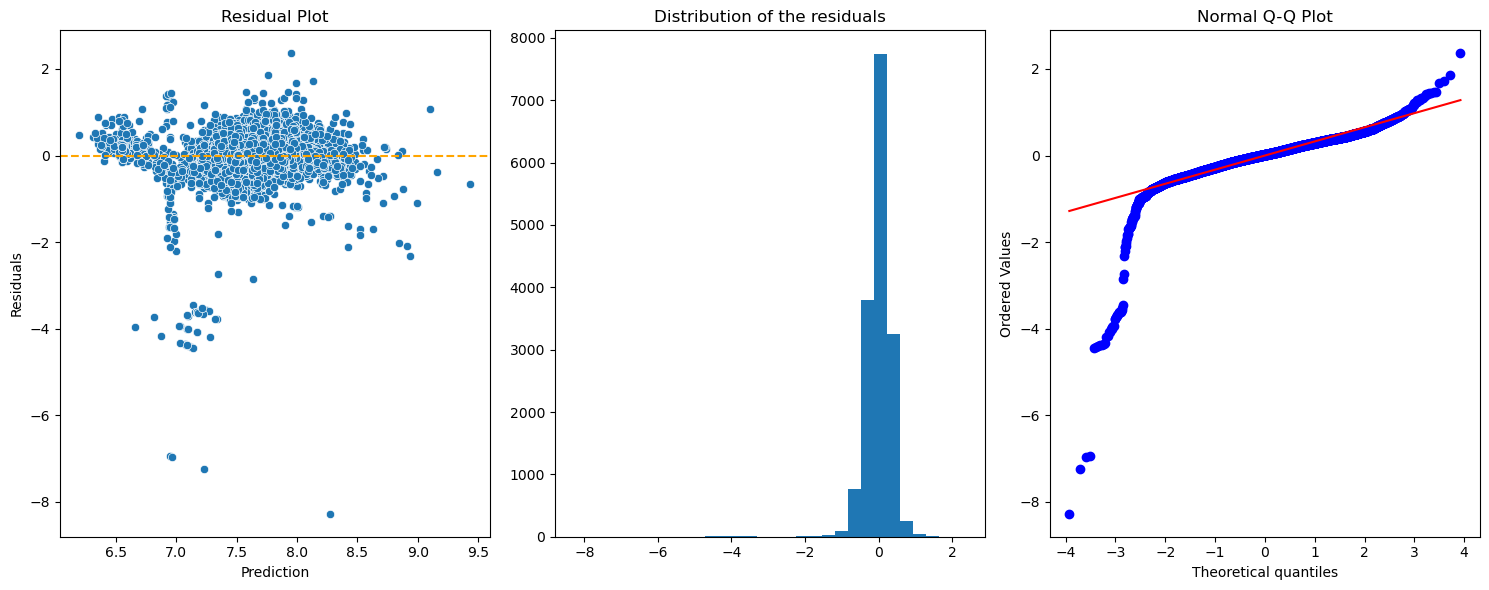

In [31]:
# Plot residuals
residual_analysis_plots(model_log)

Transforming the target variable decreases our model performance in terms of R-squared, but improves the relative RMSE. Our model is still not performing well.

### 1.4 Assess multicollinearity

In [34]:
vif_scores = pd.Series(
    [vif(X.values, i) for i in range(X.shape[1])],
    index=X.columns
)
vif_scores

beds                       8.225796
baths                     11.073266
sq_feet                    7.499978
cats                      11.280647
dogs                      10.138985
postal_code                2.166511
type_Apartment             4.714927
type_Basement              1.189042
type_Room For Rent         1.118043
furnishing_Unfurnished    10.105013
dtype: float64

In [35]:
# Remove problematic features
columns_to_keep = list(vif_scores[vif_scores <= 5].index)

In [36]:
# Re-fit model
X_train_vif = X_train[columns_to_keep]
X_test_vif = X_test[columns_to_keep]
X_constant = sm.add_constant(X_train_vif)
model_vif = sm.OLS(y_train, X_constant).fit()
model_vif.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     351.1
Date:                Sat, 01 Feb 2025   Prob (F-statistic):          3.39e-290
Time:                        11:11:19   Log-Likelihood:            -1.3158e+05
No. Observations:               16007   AIC:                         2.632e+05
Df Residuals:                   16002   BIC:                         2.632e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2394.3744     18.197    131.579      0.000    2358.706    2430.043
postal_code            0.2575      0.080      3.203      0.001       0.100       0.415
type_Apartment      -265.5749     17.499    -15.177      0.000    -299.874    -231.275
type_Basement       -870.8571     34.270    -25.412      0.000    -938.030    -803.685
type_Room For Rent -1532.6982     50.544    -30.324      0.000   -1631.769   -1433.627
==============================================================================
Omnibus:                    18447.495   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8044101.298
Skew:                           5.486   Prob(JB):                         0.00
Kurtosis:                     112.273   Cond. No.                         979.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
# Evaluate performance
X_test_constant = sm.add_constant(X_test_vif)
y_pred = model_vif.predict(X_test_constant)
compare_performances(initial_performance, eval_performance(y_test, y_pred))

,Metric,Value_initial,Value_current,Difference
0,MAE,483.7449,568.0490,84.3041
1,MSE,531141.3258,740305.7151,209164.3893
2,RMSE,728.7944,860.4102,131.6158
3,Test Mean,2168.4823,2168.4823,0.0000
4,Predictions Mean,2158.9867,2154.0145,-4.9722
5,RMSE to mean ratio,0.3361,0.3968,0.0607


Based on the R-squared, the performance of the model is much worse now. It's not a good idea to remove those features.

### 1.5 Assess outliers

The R-squared is slightly better (0.361 instead of 0.349) but the metrics are worse, which indicates our model is not good. Also, the residuals are still not normally distributed.

---

## 2. Second regression model (polynomial regression)

There seems to be non-linear relationships between variables. Let's see if we can obtain better performance with a different polynomial degree.

The best degree is 2. The RMSE starts to increase dramatically at 3.

In [45]:
# Separate features and target variable
X = df.drop('price', axis=1)
y = df['price']

In [46]:
# Create poly features
poly_converter = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly_converter.fit_transform(X)
X_poly = pd.DataFrame(poly_features, columns=poly_converter.get_feature_names_out())

In [47]:
# Train-test split 
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.15, random_state=42)

In [48]:
# Fit model
X_constant = sm.add_constant(X_train)
model_poly = sm.OLS(y_train, X_constant).fit()
model_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     213.4
Date:                Sat, 01 Feb 2025   Prob (F-statistic):               0.00
Time:                        11:11:19   Log-Likelihood:            -1.2778e+05
No. Observations:               16007   AIC:                         2.557e+05
Df Residuals:                   15950   BIC:                         2.561e+05
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                      1328.1461    102.844     12.914      0.000    1126.560    1529.732
beds                                        191.5439     47.973      3.993      0.000      97.511     285.576
baths                                       336.0057     73.186      4.591      0.000     192.554     479.458
sq_feet                                      -0.1852      0.069     -2.684      0.007      -0.321      -0.050
cats                                       -301.0377     62.342     -4.829      0.000    -423.235    -178.840
dogs                                        -33.2051     66.016     -0.503      0.615    -162.604      96.194
postal_code                                   1.2454      0.409      3.046      0.002       0.444       2.047
type_Apartment                             -134.1218     38.619     -3.473      0.001    -209.820     -58.424
type_Basement                              -206.6745     88.136     -2.345      0.019    -379.431     -33.918
type_Room For Rent                           14.1504     76.210      0.186      0.853    -135.230     163.531
furnishing_Unfurnished                      132.9413     44.220      3.006      0.003      46.265     219.618
beds^2                                      -46.3423      6.629     -6.991      0.000     -59.335     -33.349
beds baths                                   -5.7556     14.454     -0.398      0.690     -34.087      22.576
beds sq_feet                                  0.1150      0.017      6.855      0.000       0.082       0.148
beds cats                                   -35.2560     34.423     -1.024      0.306    -102.729      32.217
beds dogs                                    29.1620     33.187      0.879      0.380     -35.889      94.213
beds postal_code                              0.0090      0.107      0.084      0.933      -0.200       0.218
beds type_Apartment                         -17.4815     23.027     -0.759      0.448     -62.616      27.654
beds type_Basement                           39.6565     48.553      0.817      0.414     -55.512     134.825
beds type_Room For Rent                    -142.6382     44.578     -3.200      0.001    -230.017     -55.259
beds furnishing_Unfurnished                 102.2945     31.146      3.284      0.001      41.246     163.344
baths^2                                     -46.6046     13.622     -3.421      0.001     -73.305     -19.904
baths sq_feet                                 0.1755      0.026      6.844      0.000       0.125       0.226
baths cats                                  231.1327     51.011      4.531      0.000     131.146     331.120
baths dogs                                 -166.7072     49.628     -3.359      0.001    -263.983     -69.431
bat

**Observations**

The R-squared went from from 0.349 to 0.428, which is a good improvement.
The Durbin-Watson score of 1.989 indicates that the errors might be independent

In [50]:
# Evaluate performance
X_test_constant = sm.add_constant(X_test)
y_pred = model_poly.predict(X_test_constant)
compare_performances(initial_performance, eval_performance(y_test, y_pred))

,Metric,Value_initial,Value_current,Difference
0,MAE,483.7449,470.0687,-13.6762
1,MSE,531141.3258,494409.6362,-36731.6896
2,RMSE,728.7944,703.1427,-25.6517
3,Test Mean,2168.4823,2168.4823,0.0000
4,Predictions Mean,2158.9867,2167.9059,8.9192
5,RMSE to mean ratio,0.3361,0.3243,-0.0118


The performance of the model has improved a little bit.

In [52]:
# Re-fit model with the statistically significant variables only (95% confidence interval)
selected_features = list(model_poly.pvalues[model_poly.pvalues <= 0.05].index)[1:] # remove constant from result
X_train = X_train[selected_features]
X_test = X_test[selected_features]

X_constant = sm.add_constant(X_train)
model_poly = sm.OLS(y_train, X_constant).fit()
model_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     330.6
Date:                Sat, 01 Feb 2025   Prob (F-statistic):               0.00
Time:                        11:11:20   Log-Likelihood:            -1.2780e+05
No. Observations:               16007   AIC:                         2.557e+05
Df Residuals:                   15970   BIC:                         2.560e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                      1335.4679     91.408     14.610      0.000    1156.298    1514.638
beds                                        162.0456     35.191      4.605      0.000      93.068     231.024
baths                                       332.7736     65.965      5.045      0.000     203.475     462.073
sq_feet                                      -0.1563      0.064     -2.430      0.015      -0.282      -0.030
cats                                       -316.3399     29.930    -10.569      0.000    -375.007    -257.673
postal_code                                   1.3833      0.389      3.558      0.000       0.621       2.145
type_Apartment                             -136.7005     35.766     -3.822      0.000    -206.806     -66.596
type_Basement                              -247.7577     42.007     -5.898      0.000    -330.095    -165.420
furnishing_Unfurnished                      116.2277     40.430      2.875      0.004      36.980     195.476
beds^2                                      -45.1805      4.704     -9.605      0.000     -54.400     -35.961
beds sq_feet                                  0.1133      0.015      7.485      0.000       0.084       0.143
beds type_Room For Rent                    -130.1304     42.255     -3.080      0.002    -212.956     -47.305
beds furnishing_Unfurnished                 104.9890     29.947      3.506      0.000      46.289     163.689
baths^2                                     -53.8766     11.490     -4.689      0.000     -76.398     -31.355
baths sq_feet                                 0.1873      0.020      9.258      0.000       0.148       0.227
baths cats                                  137.9030     29.980      4.600      0.000      79.138     196.668
baths dogs                                  -75.8576     28.939     -2.621      0.009    -132.581     -19.135
baths postal_code                             0.4257      0.128      3.334      0.001       0.175       0.676
baths type_Apartment                        355.1225     25.527     13.912      0.000     305.087     405.158
baths type_Room For Rent                   -355.0474     66.853     -5.311      0.000    -486.087    -224.008
baths furnishing_Unfurnished               -202.0666     49.588     -4.075      0.000    -299.265    -104.869
sq_feet dogs                                  0.2098      0.030      6.945      0.000       0.151       0.269
sq_feet postal_code                           0.0007      0.000      4.346      0.000       0.000       0.001
sq_feet type_Apartment                        0.1946      0.034      5.679      0.000       0.127       0.262
sq_feet type_Room For Rent                   -0.6148      0.069     -8.879      0.000      -0.751      -0.479
sq_

In [53]:
# Evaluate performance
X_test_constant = sm.add_constant(X_test)
y_pred = model_poly.predict(X_test_constant)
compare_performances(initial_performance, eval_performance(y_test, y_pred))

,Metric,Value_initial,Value_current,Difference
0,MAE,483.7449,470.4584,-13.2865
1,MSE,531141.3258,494669.5929,-36471.7329
2,RMSE,728.7944,703.3275,-25.4669
3,Test Mean,2168.4823,2168.4823,0.0000
4,Predictions Mean,2158.9867,2167.2980,8.3113
5,RMSE to mean ratio,0.3361,0.3243,-0.0118


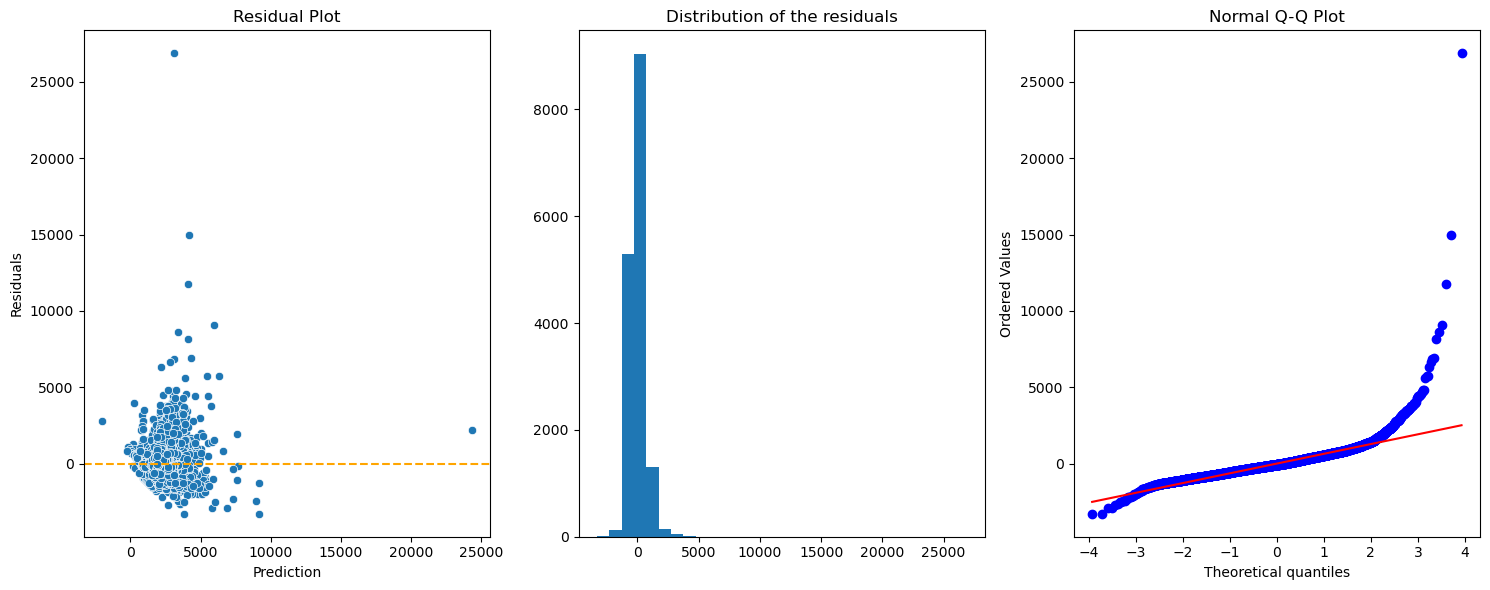

In [54]:
# Plot residuals
residual_analysis_plots(model_poly)

The residuals don't seem to be independant and normally distributed. There are still outliers if we look at the Q-Q Plot, especially the higher prices. Let's see what happens if we remove the values where the residuals are more than 2500 or more than -2500.

In [56]:
# Fit model on all data to get the outliers

# Separate features and target variable
X = df.drop('price', axis=1)
y = df['price']

# Create poly features
poly_converter = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly_converter.fit_transform(X)
X_poly = pd.DataFrame(poly_features, columns=poly_converter.get_feature_names_out())

# Fit data
X_constant = sm.add_constant(X_poly)
model_poly = sm.OLS(y, X_constant).fit()
model_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     246.1
Date:                Sat, 01 Feb 2025   Prob (F-statistic):               0.00
Time:                        11:11:21   Log-Likelihood:            -1.5030e+05
No. Observations:               18832   AIC:                         3.007e+05
Df Residuals:                   18775   BIC:                         3.012e+05
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                      1421.0597     93.311     15.229      0.000    1238.161    1603.958
beds                                        208.6268     44.432      4.695      0.000     121.535     295.718
baths                                       247.7888     67.471      3.673      0.000     115.539     380.038
sq_feet                                      -0.1527      0.064     -2.401      0.016      -0.277      -0.028
cats                                       -330.3944     57.297     -5.766      0.000    -442.701    -218.088
dogs                                          1.1085     61.264      0.018      0.986    -118.975     121.192
postal_code                                   1.3157      0.375      3.505      0.000       0.580       2.051
type_Apartment                             -135.2910     35.442     -3.817      0.000    -204.760     -65.822
type_Basement                              -199.0101     80.396     -2.475      0.013    -356.594     -41.427
type_Room For Rent                          -38.1552     71.006     -0.537      0.591    -177.334     101.024
furnishing_Unfurnished                       67.9956     40.143      1.694      0.090     -10.689     146.680
beds^2                                      -50.5623      6.208     -8.144      0.000     -62.731     -38.393
beds baths                                   -8.0775     13.784     -0.586      0.558     -35.095      18.940
beds sq_feet                                  0.1109      0.016      7.030      0.000       0.080       0.142
beds cats                                   -44.7188     32.024     -1.396      0.163    -107.489      18.051
beds dogs                                    38.0641     30.918      1.231      0.218     -22.539      98.667
beds postal_code                              0.0135      0.100      0.135      0.893      -0.182       0.209
beds type_Apartment                         -35.6273     21.211     -1.680      0.093     -77.202       5.948
beds type_Basement                           28.1464     45.234      0.622      0.534     -60.517     116.810
beds type_Room For Rent                    -105.1074     41.299     -2.545      0.011    -186.057     -24.158
beds furnishing_Unfurnished                 114.4703     28.718      3.986      0.000      58.180     170.761
baths^2                                     -30.1817     13.031     -2.316      0.021     -55.724      -4.640
baths sq_feet                                 0.1779      0.024      7.298      0.000       0.130       0.226
baths cats                                  233.9236     47.721      4.902      0.000     140.385     327.462
baths dogs                                 -154.0833     46.494     -3.314      0.001    -245.216     -62.951
bat

In [57]:
# Evaluate performance
y_pred = model_poly.predict(X_constant)
compare_performances(initial_performance, eval_performance(y, y_pred))

,Metric,Value_initial,Value_current,Difference
0,MAE,483.7449,472.2605,-11.4844
1,MSE,531141.3258,501011.7000,-30129.6258
2,RMSE,728.7944,707.8218,-20.9726
3,Test Mean,2168.4823,2156.9496,-11.5327
4,Predictions Mean,2158.9867,2156.9496,-2.0371
5,RMSE to mean ratio,0.3361,0.3282,-0.0079


In [58]:
# Get residuals
residuals = y - y_pred
residuals

0        -78.514171
1       -133.312084
2       -174.883514
3       -478.514171
4        -54.322665
            ...    
18827   -666.405933
18828   -808.330302
18829   -752.707822
18830   -666.405933
18831   -828.413432
Length: 18832, dtype: float64

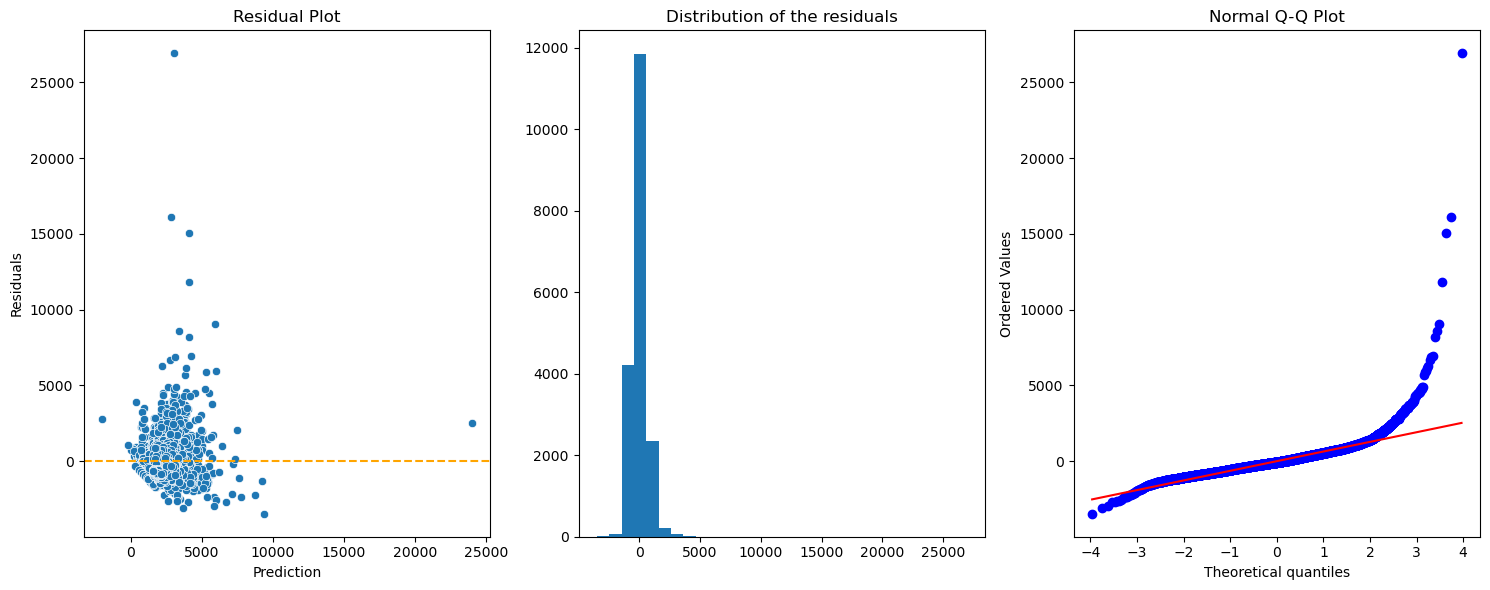

In [59]:
residual_analysis_plots(model_poly)

In [60]:
pos_outliers = set(residuals[(residuals < -2500) | (residuals > 2500)].index)
pos_outliers

{206,
 207,
 641,
 642,
 762,
 809,
 822,
 1150,
 1165,
 1458,
 1546,
 1591,
 1977,
 2142,
 2287,
 2438,
 3117,
 3436,
 3599,
 3657,
 3766,
 3998,
 4011,
 4016,
 4051,
 4116,
 4128,
 4129,
 4145,
 4156,
 4191,
 4216,
 4317,
 4399,
 4611,
 4616,
 4713,
 5202,
 5538,
 5656,
 6262,
 6298,
 6855,
 7703,
 8269,
 8276,
 8292,
 8538,
 9033,
 9037,
 9063,
 9137,
 9142,
 9176,
 9297,
 9368,
 9370,
 9373,
 9375,
 9376,
 9378,
 9379,
 9414,
 9531,
 10093,
 10094,
 10140,
 10141,
 10142,
 10143,
 10144,
 10145,
 11883,
 13218,
 13530,
 13531,
 13542,
 13800,
 13801,
 13855,
 13856,
 13859,
 13904,
 13911,
 13912,
 13913,
 13927,
 13928,
 13953,
 13955,
 13956,
 13957,
 13958,
 13975,
 14137,
 14138,
 14724,
 14725,
 14727,
 14808,
 14842,
 14970,
 15149,
 15171,
 15186,
 15187,
 15188,
 15189,
 15190,
 15191,
 15248,
 15390,
 15391,
 15513,
 15623,
 15788,
 15789,
 16460,
 16551,
 16554,
 16796,
 16993,
 17380,
 17412,
 17421,
 17596,
 17653,
 17898,
 18621}

In [61]:
print(len(df))
df = df.drop(pos_outliers).reset_index(drop=True)
print(len(df))

18832
18703


In [62]:
# Re-fit model

# Separate features and target variable
X = df.drop('price', axis=1)
y = df['price']

# Create poly features
poly_converter = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly_converter.fit_transform(X)
X_poly = pd.DataFrame(poly_features, columns=poly_converter.get_feature_names_out())

# Fit data
X_constant = sm.add_constant(X_poly)
model_poly = sm.OLS(y, X_constant).fit()
model_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     280.1
Date:                Sat, 01 Feb 2025   Prob (F-statistic):               0.00
Time:                        11:11:23   Log-Likelihood:            -1.4533e+05
No. Observations:               18703   AIC:                         2.908e+05
Df Residuals:                   18646   BIC:                         2.912e+05
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                      1442.4059     80.847     17.841      0.000    1283.939    1600.873
beds                                        256.2524     37.002      6.925      0.000     183.725     328.780
baths                                       268.8973     56.620      4.749      0.000     157.917     379.877
sq_feet                                      -0.1615      0.063     -2.568      0.010      -0.285      -0.038
cats                                       -355.8449     47.030     -7.566      0.000    -448.029    -263.661
dogs                                         44.9910     50.145      0.897      0.370     -53.298     143.280
postal_code                                   1.5864      0.308      5.155      0.000       0.983       2.190
type_Apartment                             -130.4705     29.684     -4.395      0.000    -188.654     -72.287
type_Basement                              -166.3729     65.480     -2.541      0.011    -294.719     -38.027
type_Room For Rent                         -199.7135     59.761     -3.342      0.001    -316.850     -82.577
furnishing_Unfurnished                     -109.1237     33.303     -3.277      0.001    -174.401     -43.846
beds^2                                      -50.6182      5.135     -9.858      0.000     -60.683     -40.554
beds baths                                  -26.0029     12.013     -2.165      0.030     -49.549      -2.457
beds sq_feet                                  0.1349      0.013     10.209      0.000       0.109       0.161
beds cats                                   -68.1122     26.113     -2.608      0.009    -119.297     -16.928
beds dogs                                    52.3121     25.170      2.078      0.038       2.976     101.648
beds postal_code                              0.0166      0.081      0.204      0.838      -0.143       0.176
beds type_Apartment                         -69.9452     17.343     -4.033      0.000    -103.939     -35.952
beds type_Basement                           -9.5328     36.750     -0.259      0.795     -81.567      62.501
beds type_Room For Rent                    -155.4650     34.052     -4.565      0.000    -222.211     -88.719
beds furnishing_Unfurnished                  99.4047     23.978      4.146      0.000      52.406     146.404
baths^2                                     -19.6093     10.773     -1.820      0.069     -40.726       1.507
baths sq_feet                                 0.1164      0.023      5.024      0.000       0.071       0.162
baths cats                                  234.0880     38.790      6.035      0.000     158.056     310.120
baths dogs                                 -179.4156     37.778     -4.749      0.000    -253.463    -105.368
bat

In [63]:
# Re fit model with statistically significant features
selected_features = list(model_poly.pvalues[model_poly.pvalues <= 0.05].index)[1:] # remove constant from result
X_poly = X_poly[selected_features]

X_constant = sm.add_constant(X_poly)
model_poly = sm.OLS(y, X_constant).fit()
model_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     382.3
Date:                Sat, 01 Feb 2025   Prob (F-statistic):               0.00
Time:                        11:11:23   Log-Likelihood:            -1.4534e+05
No. Observations:               18703   AIC:                         2.908e+05
Df Residuals:                   18661   BIC:                         2.911e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                      1480.3883     72.977     20.286      0.000    1337.346    1623.430
beds                                        264.9016     32.329      8.194      0.000     201.533     328.270
baths                                       227.6157     50.502      4.507      0.000     128.627     326.604
sq_feet                                      -0.1629      0.055     -2.970      0.003      -0.270      -0.055
cats                                       -315.5495     25.135    -12.554      0.000    -364.817    -266.282
postal_code                                   1.5322      0.242      6.335      0.000       1.058       2.006
type_Apartment                             -140.0824     28.497     -4.916      0.000    -195.940     -84.225
type_Basement                              -263.5833     31.925     -8.256      0.000    -326.160    -201.007
type_Room For Rent                         -202.8962     50.041     -4.055      0.000    -300.982    -104.810
furnishing_Unfurnished                     -109.5218     28.429     -3.852      0.000    -165.246     -53.797
beds^2                                      -50.5356      5.040    -10.028      0.000     -60.414     -40.657
beds baths                                  -33.5110     10.910     -3.072      0.002     -54.896     -12.126
beds sq_feet                                  0.1411      0.013     11.094      0.000       0.116       0.166
beds cats                                   -71.9872     23.066     -3.121      0.002    -117.199     -26.775
beds dogs                                    57.0434     22.258      2.563      0.010      13.416     100.671
beds type_Apartment                         -71.4225     15.863     -4.503      0.000    -102.515     -40.330
beds type_Room For Rent                    -142.5753     32.899     -4.334      0.000    -207.059     -78.091
beds furnishing_Unfurnished                  96.4152     23.441      4.113      0.000      50.469     142.361
baths sq_feet                                 0.1010      0.021      4.850      0.000       0.060       0.142
baths cats                                  222.7290     33.336      6.681      0.000     157.388     288.070
baths dogs                                 -165.2075     31.655     -5.219      0.000    -227.253    -103.162
baths postal_code                             0.3350      0.089      3.775      0.000       0.161       0.509
baths type_Apartment                        313.3843     23.227     13.492      0.000     267.857     358.911
baths type_Room For Rent                   -399.4594     53.586     -7.455      0.000    -504.493    -294.426
baths furnishing_Unfurnished                -81.3129     37.905     -2.145      0.032    -155.611      -7.015
sq_

In [64]:
y_pred = model_poly.predict(X_constant)
compare_performances(initial_performance, eval_performance(y, y_pred))

,Metric,Value_initial,Value_current,Difference
0,MAE,483.7449,439.2096,-44.5353
1,MSE,531141.3258,329060.4807,-202080.8451
2,RMSE,728.7944,573.6379,-155.1565
3,Test Mean,2168.4823,2123.1878,-45.2945
4,Predictions Mean,2158.9867,2123.1878,-35.7989
5,RMSE to mean ratio,0.3361,0.2702,-0.0659


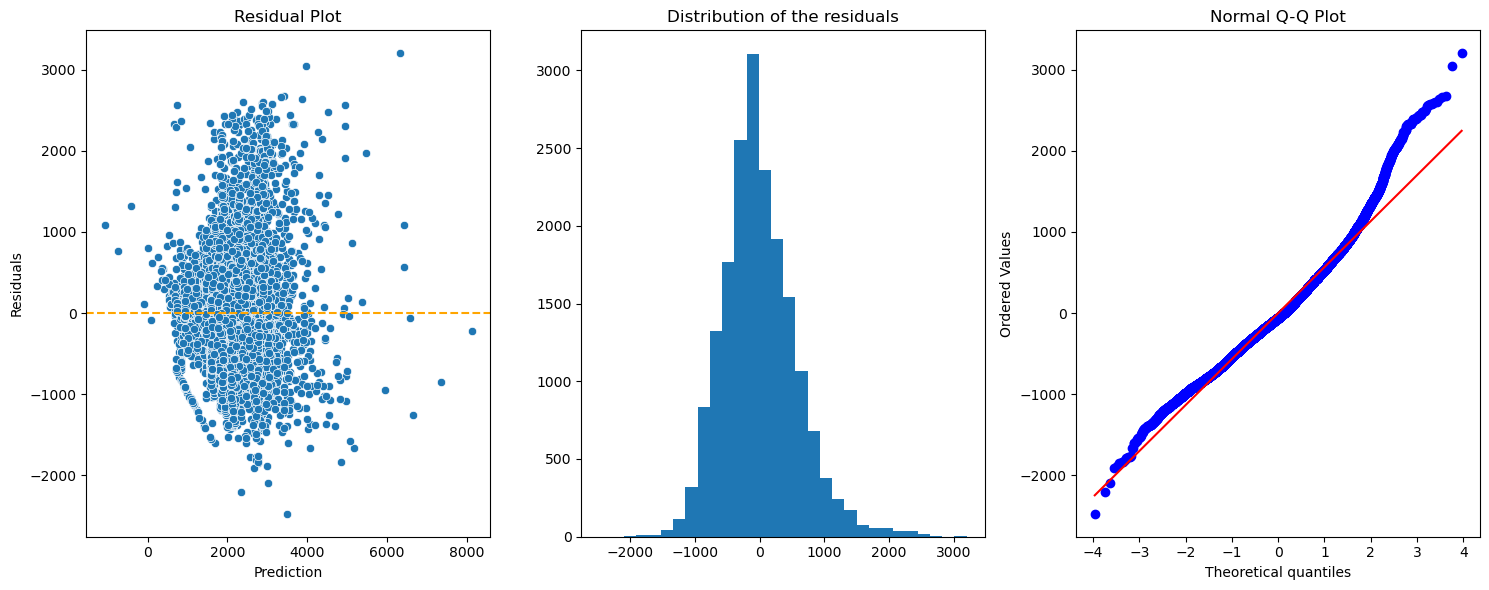

In [65]:
# Plot residuals
residual_analysis_plots(model_poly)

In [66]:
# Get residuals
residuals = y - y_pred

pos_outliers = set(residuals[(residuals < -1500) | (residuals > 1500)].index)

print(len(df))
df = df.drop(pos_outliers).reset_index(drop=True)
print(len(df))

18703
18390


In [67]:
# Separate features and target variable
X = df.drop('price', axis=1)
y = df['price']

# Create poly features
poly_converter = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly_converter.fit_transform(X)
X_poly = pd.DataFrame(poly_features, columns=poly_converter.get_feature_names_out())

# Fit data
X_constant = sm.add_constant(X_poly)
model_poly = sm.OLS(y, X_constant).fit()
model_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     291.7
Date:                Sat, 01 Feb 2025   Prob (F-statistic):               0.00
Time:                        11:11:25   Log-Likelihood:            -1.4098e+05
No. Observations:               18390   AIC:                         2.821e+05
Df Residuals:                   18333   BIC:                         2.825e+05
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                      1509.4651     74.452     20.274      0.000    1363.533    1655.397
beds                                        308.5474     34.188      9.025      0.000     241.536     375.559
baths                                       197.2205     52.387      3.765      0.000      94.536     299.905
sq_feet                                      -0.2216      0.058     -3.811      0.000      -0.336      -0.108
cats                                       -336.1604     43.005     -7.817      0.000    -420.454    -251.866
dogs                                         47.1666     46.206      1.021      0.307     -43.402     137.735
postal_code                                   1.5219      0.282      5.400      0.000       0.969       2.074
type_Apartment                             -115.9552     27.265     -4.253      0.000    -169.397     -62.514
type_Basement                              -149.3285     59.156     -2.524      0.012    -265.279     -33.378
type_Room For Rent                         -252.5707     54.353     -4.647      0.000    -359.108    -146.033
furnishing_Unfurnished                     -183.3946     31.040     -5.908      0.000    -244.236    -122.553
beds^2                                      -51.4728      4.765    -10.803      0.000     -60.812     -42.133
beds baths                                  -21.3003     11.054     -1.927      0.054     -42.968       0.367
beds sq_feet                                  0.1369      0.012     11.123      0.000       0.113       0.161
beds cats                                   -52.6934     24.057     -2.190      0.029     -99.847      -5.539
beds dogs                                    21.9745     23.187      0.948      0.343     -23.474      67.423
beds postal_code                             -0.1289      0.076     -1.703      0.089      -0.277       0.019
beds type_Apartment                         -81.3829     16.035     -5.075      0.000    -112.813     -49.953
beds type_Basement                          -27.2624     33.270     -0.819      0.413     -92.475      37.950
beds type_Room For Rent                    -194.2068     31.728     -6.121      0.000    -256.397    -132.016
beds furnishing_Unfurnished                  66.0365     23.059      2.864      0.004      20.840     111.233
baths^2                                     -18.0616      9.879     -1.828      0.068     -37.425       1.301
baths sq_feet                                 0.0928      0.022      4.256      0.000       0.050       0.136
baths cats                                  249.6181     35.501      7.031      0.000     180.033     319.203
baths dogs                                 -192.7185     34.556     -5.577      0.000    -260.451    -124.986
bat

In [68]:
# Re fit model with statistically significant features
selected_features = list(model_poly.pvalues[model_poly.pvalues <= 0.05].index)[1:] # remove constant from result
X_poly = X_poly[selected_features]

X_constant = sm.add_constant(X_poly)
model_poly = sm.OLS(y, X_constant).fit()
model_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     417.6
Date:                Sat, 01 Feb 2025   Prob (F-statistic):               0.00
Time:                        11:11:25   Log-Likelihood:            -1.4100e+05
No. Observations:               18390   AIC:                         2.821e+05
Df Residuals:                   18350   BIC:                         2.824e+05
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                      1605.4640     62.016     25.888      0.000    1483.907    1727.021
beds                                        294.5488     26.772     11.002      0.000     242.073     347.025
baths                                       135.6620     31.892      4.254      0.000      73.151     198.173
sq_feet                                      -0.2499      0.043     -5.867      0.000      -0.333      -0.166
cats                                       -298.1631     23.687    -12.588      0.000    -344.591    -251.735
postal_code                                   1.4340      0.220      6.515      0.000       1.003       1.865
type_Apartment                             -143.0338     26.022     -5.497      0.000    -194.040     -92.028
type_Basement                              -247.4198     28.305     -8.741      0.000    -302.900    -191.939
type_Room For Rent                         -305.0467     34.734     -8.782      0.000    -373.129    -236.965
furnishing_Unfurnished                     -172.1863     23.799     -7.235      0.000    -218.834    -125.539
beds^2                                      -59.1490      3.561    -16.608      0.000     -66.130     -52.168
beds sq_feet                                  0.1489      0.012     12.702      0.000       0.126       0.172
beds cats                                   -30.6833     13.354     -2.298      0.022     -56.858      -4.509
beds type_Apartment                         -76.0774     14.579     -5.218      0.000    -104.654     -47.501
beds type_Room For Rent                    -208.7511     27.961     -7.466      0.000    -263.558    -153.944
beds furnishing_Unfurnished                  52.9937     18.128      2.923      0.003      17.462      88.526
baths sq_feet                                 0.0503      0.017      2.922      0.003       0.017       0.084
baths cats                                  234.4645     30.910      7.585      0.000     173.878     295.050
baths dogs                                 -172.5271     27.616     -6.247      0.000    -226.656    -118.398
baths postal_code                             0.3642      0.082      4.456      0.000       0.204       0.524
baths type_Apartment                        247.1994     20.982     11.782      0.000     206.073     288.326
baths type_Room For Rent                   -310.5327     40.617     -7.645      0.000    -390.146    -230.919
sq_feet^2                                 -8.033e-06   4.48e-06     -1.793      0.073   -1.68e-05    7.49e-07
sq_feet cats                                 -0.1108      0.041     -2.685      0.007      -0.192      -0.030
sq_feet dogs                                  0.2610      0.039      6.684      0.000       0.184       0.338
sq_

In [69]:
y_pred = model_poly.predict(X_constant)
compare_performances(initial_performance, eval_performance(y, y_pred))

,Metric,Value_initial,Value_current,Difference
0,MAE,483.7449,409.4445,-74.3004
1,MSE,531141.3258,267405.7842,-263735.5416
2,RMSE,728.7944,517.1129,-211.6815
3,Test Mean,2168.4823,2086.0823,-82.4000
4,Predictions Mean,2158.9867,2086.0823,-72.9044
5,RMSE to mean ratio,0.3361,0.2479,-0.0882


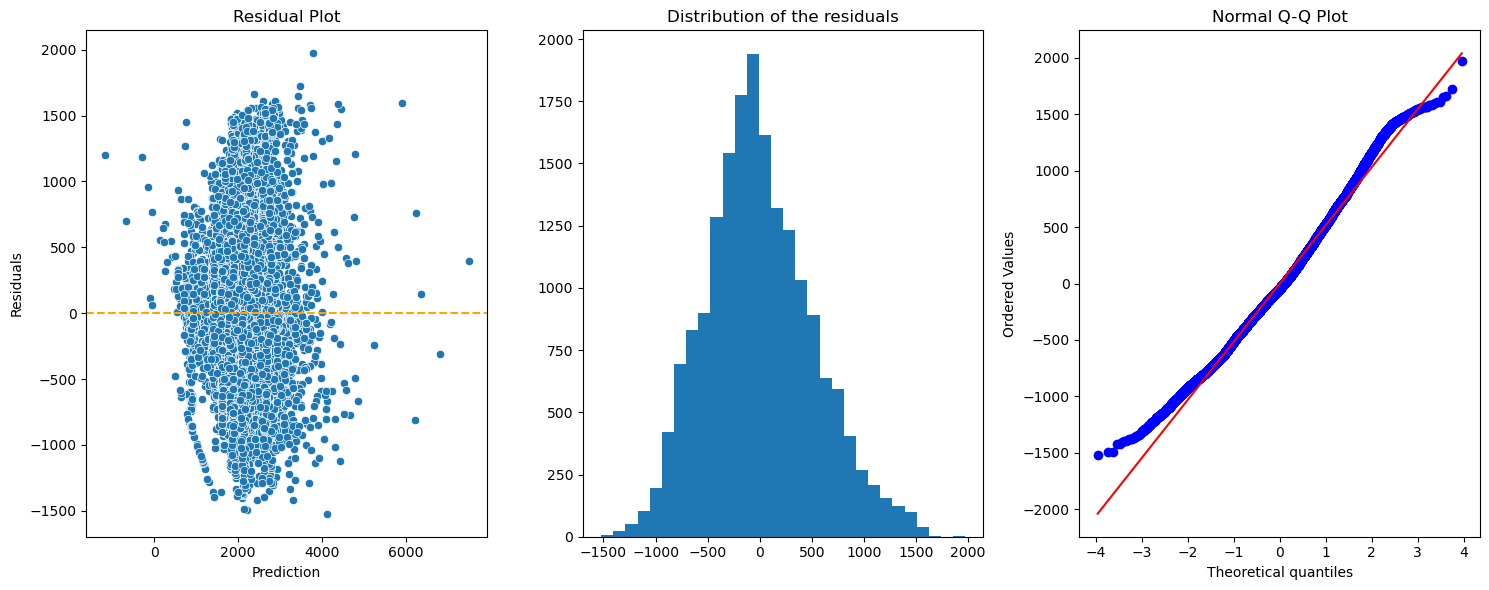

In [70]:
# Plot residuals
residual_analysis_plots(model_poly)

---

## 3. Third model (regularization, cross-validation and grid search)

## End